In [ ]:
import pandas as pd
import pprint
from constants import DB_DRIVER_NAMES, DEFAULT_BASE_LAP, API_TO_DB_FORMAT
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

drivers_initial = []
drivers_2 = []
try:
    quali_df = pd.read_csv('all_quali_data.csv')
    race_df = pd.read_csv('all_race_data.csv')
except FileNotFoundError:
    print("Error finding files")

starting_data = {}
position_changes = {}
pole_retention = {}










In [22]:
#Code to add positions onto the drivers in qualifying. Ordering by time causes errors and inconsistencies so this is necessary. 
# starting_positions = []

# # Initialize the current race name tracker and position counter
# current_race = None
# position = 1

# # Loop through the DataFrame and assign starting positions based on race changes
# for index, row in quali_df.iterrows():
#     race_name = row['race_name']
    
#     #rest if the race is a new race
#     if race_name != current_race:
#         position = 1  
#         current_race = race_name
    
#     starting_positions.append(position)
    

#     position += 1
# quali_df['Starting_Position'] = starting_positions
# quali_df.to_csv('all_quali_data.csv', index=False)


In [23]:



RACE_NAME_FULL = {
    "bahrain": "Bahrain Grand Prix",
    "saudi-arabia": "Saudi Arabian Grand Prix",
    "australia": "Australian Grand Prix",
    "japan": "Japanese Grand Prix",
    "china": "Chinese Grand Prix",
    "miami": "Miami Grand Prix",
    "emilia-romagna": "Emilia Romagna Grand Prix",
    "monaco": "Monaco Grand Prix",
    "canada": "Canadian Grand Prix",
    "spain": "Spanish Grand Prix",
    "austria": "Austrian Grand Prix",
    "great-britain": "British Grand Prix",
    "hungary": "Hungarian Grand Prix",
    "belgium": "Belgian Grand Prix",
    "netherlands": "Dutch Grand Prix",
    "italy": "Italian Grand Prix",
    "azerbijan": "Azerbaijan Grand Prix",
    "singapore": "Singapore Grand Prix",
    "united-states": "United States Grand Prix",
    "mexico": "Mexico City Grand Prix",
    "sao-paulo": "São Paulo Grand Prix",
    "las-vegas": "Las Vegas Grand Prix",
    "qatar": "Qatar Grand Prix",
    "abu-dhabi": "Abu Dhabi Grand Prix"
}

In [24]:
#Cell to convert names of races and drivers to the correct format.
def convert_to_full_race_name(race_name_abbrev):
    return RACE_NAME_FULL.get(race_name_abbrev.lower(), race_name_abbrev.title()) 

def convert_to_db_format(driver_id_api):
    return API_TO_DB_FORMAT.get(driver_id_api, driver_id_api)

def get_base_time(race, year, driver):
    base_time = (quali_df[(quali_df.year == year) & (quali_df.race_name == f"{race}") & (quali_df.driver == f"{driver}")])
    if base_time.empty:
        return DEFAULT_BASE_LAP[f"{race}"]
    return float(base_time.iloc[0, 3])

In [25]:
#Method ot retrieve the starting positions for each driver in each race. 
def get_starting_position(year):
    for (year, race_name), group in quali_df.groupby(['year', 'race_name']):
        race_name = convert_to_full_race_name(race_name)
        valid_drivers = group[group['Qualifying_time'] > 0]

        group_sorted = valid_drivers.sort_values(by='Starting_Position')
        if year not in starting_data:
            starting_data[year] = {}
        starting_data[year][race_name] = {}

        for position, (_, row) in enumerate(group_sorted.iterrows(), 1):
            driver_id = row['driver']
            qualifying_time = row['Qualifying_time']
            position = row['Starting_Position']

            starting_data[year][race_name][driver_id] = {
            'starting_position': position,  # The position after sorting by qualifying time
            'qualifying_time': qualifying_time,
            'position_after_lap_1': None, 
            }
    return starting_data

In [26]:
#Method that gets the positions of the drivers after the end of the first lap. 
def get_lap_1_positions(year, data):
    lap_1_data = race_df[race_df['lap_number'] == 1]
    for _, row in lap_1_data.iterrows():
        year = row['year']
        race_name = row['race_name']
        driver_id = row['driver_id']
        driver_id = convert_to_db_format(driver_id)
        position_lap_1 = row['position']

        if year in data and race_name in data[year]:
            if driver_id in data[year][race_name]:
                data[year][race_name][driver_id]['position_after_lap_1'] = position_lap_1
    return data

In [27]:
#Method that calculates the total number of positions gained or lost for each driver.
def get_position_change(data):
    for driver in DB_DRIVER_NAMES:
        for year in data:
            for race in data[year]:
                if driver in data[year][race]:
                    starting_position = data[year][race][driver]["starting_position"]
                    lap_1_position = data[year][race][driver]["position_after_lap_1"]
                    if (starting_position == 1):
                        if driver not in pole_retention:
                            pole_retention[driver] = {"kept_pole": 0, "total_poles": 0}
                        pole_retention[driver]["total_poles"] += 1
                        if lap_1_position == 1:
                            pole_retention[driver]["kept_pole"] += 1
                    if lap_1_position != None:
                        position_change = starting_position - lap_1_position
                    else:
                        position_change = 0
                    if driver not in position_changes:
                        position_changes[driver] = 0
                    position_changes[driver] += position_change
    return position_changes, pole_retention

In [28]:

starting_data = get_starting_position(2024)
data = get_lap_1_positions(2024, starting_data)
position_changes, pole_retention = get_position_change(data)
position_changes = sorted(position_changes.items(), key=lambda item: item[1])
pprint.pprint(position_changes)

[('sergio-perez', -25),
 ('george-russell', -22),
 ('carlos-sainz-jr', -20),
 ('valtteri-bottas', -19),
 ('daniel-ricciardo', -17),
 ('charles-leclerc', -10),
 ('lando-norris', -6),
 ('pierre-gasly', 0),
 ('max-verstappen', 1),
 ('alexander-albon', 4),
 ('liam-lawson', 5),
 ('nico-hulkenberg', 8),
 ('fernando-alonso', 12),
 ('franco-colapinto', 12),
 ('lance-stroll', 20),
 ('yuki-tsunoda', 21),
 ('esteban-ocon', 21),
 ('lewis-hamilton', 27),
 ('oscar-piastri', 27),
 ('logan-sargeant', 28),
 ('guanyu-zhou', 30),
 ('kevin-magnussen', 40)]


In [29]:
#Plots a graph that represents positon changes.
def plot_position_changes(data):
    data.sort(key=lambda x: x[1], reverse=True)
    drivers, positions = zip(*data)

    plt.figure(figsize=(15,9))
    sns.barplot(x=drivers, y=positions, palette="coolwarm")
    plt.xticks(rotation=45)  # Rotate driver names for readability
    plt.xlabel("Drivers")
    plt.ylabel("Total Positions Gained/Lost")
    plt.title("Total Positions Gained/Lost on Lap 1")
    plt.show()

In [30]:
#Plots a chart that represents the pole retention rates.
def plot_pole_retention(data):
    print(data)
    drivers = list(data.keys())
    pole_retention = [data['kept_pole'] / data['total_poles'] if data['total_poles'] > 0 else 0 
                      for data in data.values()] 

    plt.figure(figsize=(12, 6))
    sns.barplot(y=drivers, x=pole_retention, palette="coolwarm", orient='h')  # Horizontal bars

    plt.axvline(0, color='black', linewidth=1)  # Zero baseline
    plt.xlabel("Pole Retention Ratio")
    plt.ylabel("Drivers")
    plt.title("Pole Retention by Drivers")
    plt.show()


{'carlos-sainz-jr': {'kept_pole': 2, 'total_poles': 5}, 'charles-leclerc': {'kept_pole': 1, 'total_poles': 15}, 'george-russell': {'kept_pole': 2, 'total_poles': 3}, 'kevin-magnussen': {'kept_pole': 0, 'total_poles': 1}, 'lando-norris': {'kept_pole': 1, 'total_poles': 7}, 'lewis-hamilton': {'kept_pole': 0, 'total_poles': 1}, 'max-verstappen': {'kept_pole': 18, 'total_poles': 30}, 'sergio-perez': {'kept_pole': 1, 'total_poles': 3}}


/tmp/ipykernel_45963/2224402389.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=drivers, x=pole_retention, palette="coolwarm", orient='h')  # Horizontal bars


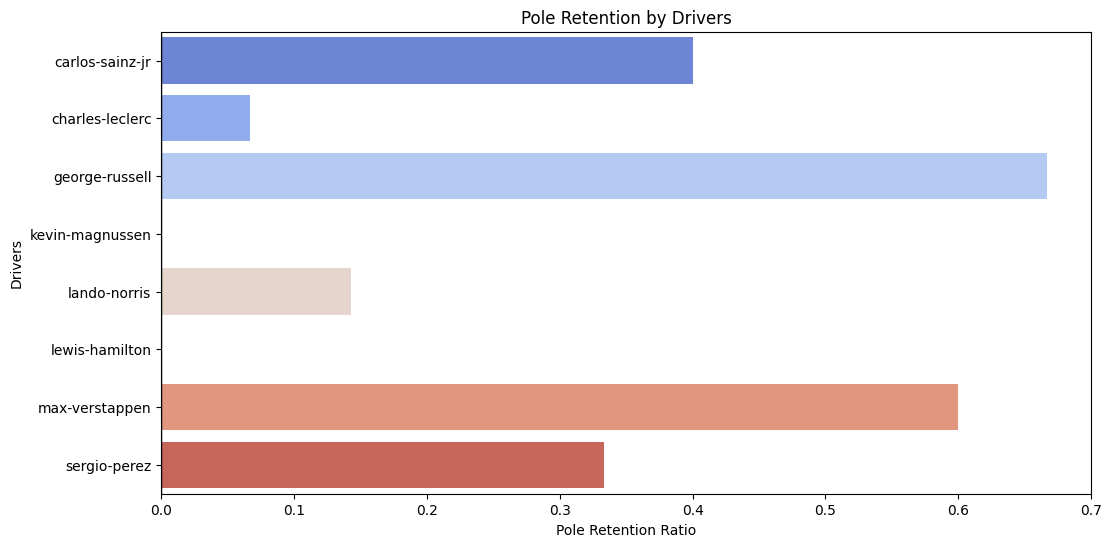

In [31]:
plot_pole_retention(pole_retention)

/tmp/ipykernel_45963/1197804011.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=drivers, y=positions, palette="coolwarm")


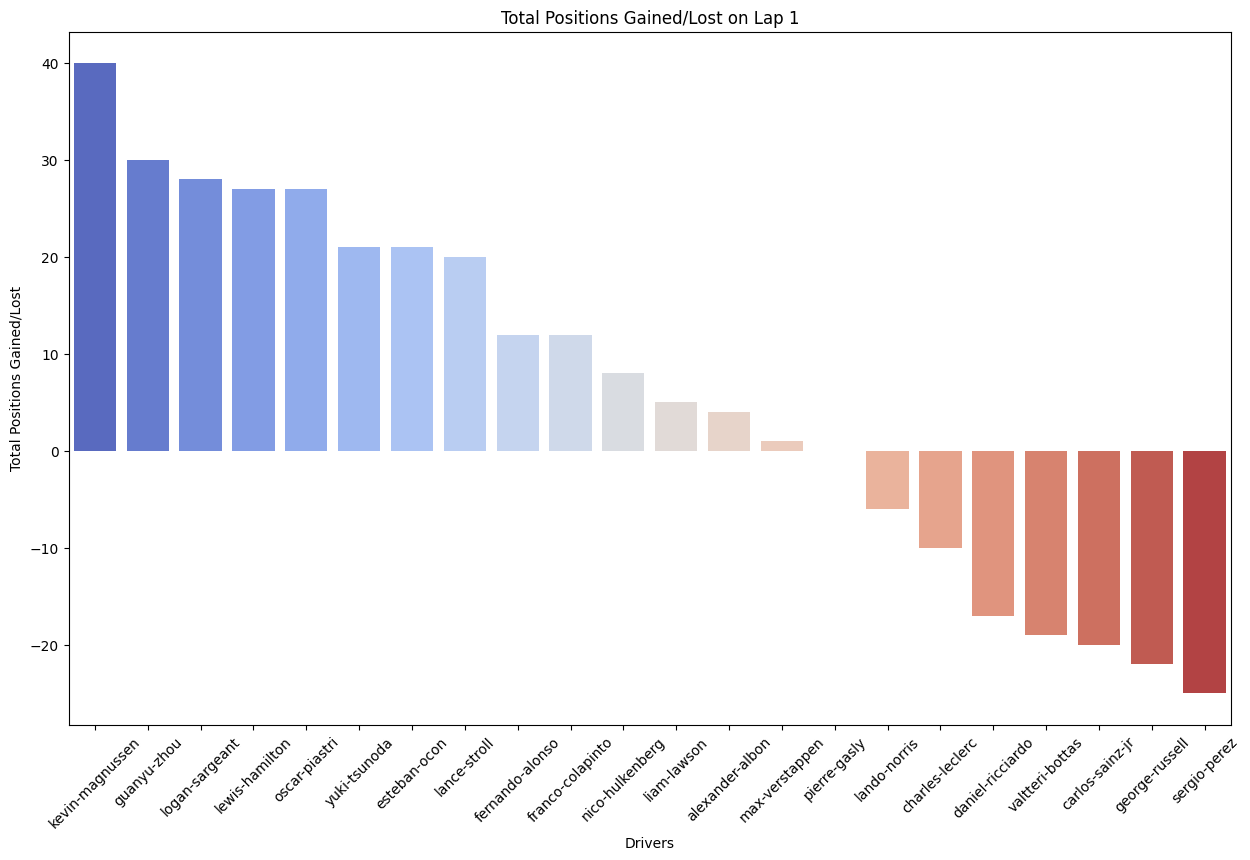

In [32]:
plot_position_changes(position_changes)

In [34]:
#Cell that creates the final dataframe for the useful bits of data.
df = pd.DataFrame.from_dict(dict(position_changes), orient="index", columns=["positions_gained_lost"])

df["pole_retention"] = df.index.map(lambda driver: pole_retention.get(driver, 0))

df['kept_pole'] = df["pole_retention"].apply(lambda x: x['kept_pole'] if isinstance(x, dict) else None)
df['total_poles'] = df['pole_retention'].apply(lambda x: x['total_poles'] if isinstance(x, dict) else None)
df['pole_retention_percentage'] = df.apply(lambda row: (row['kept_pole'] / row['total_poles'] * 100) 
                                            if row['total_poles'] and row['total_poles'] > 0 else None, axis=1)
df.drop(columns=['pole_retention'], inplace=True)
print(df)

                  positions_gained_lost  kept_pole  total_poles  \
kevin-magnussen                      40        0.0          1.0   
guanyu-zhou                          30        NaN          NaN   
logan-sargeant                       28        NaN          NaN   
lewis-hamilton                       27        0.0          1.0   
oscar-piastri                        27        NaN          NaN   
yuki-tsunoda                         21        NaN          NaN   
esteban-ocon                         21        NaN          NaN   
lance-stroll                         20        NaN          NaN   
fernando-alonso                      12        NaN          NaN   
franco-colapinto                     12        NaN          NaN   
nico-hulkenberg                       8        NaN          NaN   
liam-lawson                           5        NaN          NaN   
alexander-albon                       4        NaN          NaN   
max-verstappen                        1       18.0         30.

In [36]:
#This is the attempt at GBR, the results are not as accurate as the model requires.

df['pole_retention_percentage'].fillna(0, inplace=True)
df['total_poles'].fillna(0, inplace=True)


max_poles = df['total_poles'].max()
alpha = 20 #This is how much the total poles affect the rating

df['adjusted_pole_retention'] = (df['pole_retention_percentage'] * (df['total_poles'] / (df['total_poles'].max() + 1))) + alpha * (df['total_poles'] / max_poles)

scaler_positions = MinMaxScaler()
df['positions_gained_lost'] = scaler_positions.fit_transform(df[['positions_gained_lost']])

scaler_poles = MinMaxScaler()
df['adjusted_pole_retention'] = scaler_poles.fit_transform(df[['adjusted_pole_retention']])


X = df[['positions_gained_lost', 'adjusted_pole_retention']]
y = df['positions_gained_lost']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
gbr.fit(X_train, y_train)
df['start_rating'] = gbr.predict(X)
df.sort_values(by='start_rating', ascending=False)

print(df)

                  positions_gained_lost  kept_pole  total_poles  \
kevin-magnussen                1.000000        0.0          1.0   
guanyu-zhou                    0.846154        NaN          0.0   
logan-sargeant                 0.815385        NaN          0.0   
lewis-hamilton                 0.800000        0.0          1.0   
oscar-piastri                  0.800000        NaN          0.0   
yuki-tsunoda                   0.707692        NaN          0.0   
esteban-ocon                   0.707692        NaN          0.0   
lance-stroll                   0.692308        NaN          0.0   
fernando-alonso                0.569231        NaN          0.0   
franco-colapinto               0.569231        NaN          0.0   
nico-hulkenberg                0.507692        NaN          0.0   
liam-lawson                    0.461538        NaN          0.0   
alexander-albon                0.446154        NaN          0.0   
max-verstappen                 0.400000       18.0         30.

/tmp/ipykernel_45963/1239658455.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pole_retention_percentage'].fillna(0, inplace=True)
/tmp/ipykernel_45963/1239658455.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [37]:
#This cell focuses on Random Forest Regressor, the results are equally as insufficient. 
rfr = RandomForestRegressor(n_estimators=200, 
                            random_state=42,
                            max_features='sqrt', 
                            min_samples_split=2,   
                            min_samples_leaf=1,   
                            max_depth=10) 
rfr.fit(X_train, y_train)

df['start_rating'] = rfr.predict(X)

print(df[['start_rating']])

                  start_rating
kevin-magnussen       0.800385
guanyu-zhou           0.800923
logan-sargeant        0.800923
lewis-hamilton        0.797077
oscar-piastri         0.793846
yuki-tsunoda          0.710231
esteban-ocon          0.710231
lance-stroll          0.702154
fernando-alonso       0.545462
franco-colapinto      0.545462
nico-hulkenberg       0.502385
liam-lawson           0.459154
alexander-albon       0.447462
max-verstappen        0.318615
pierre-gasly          0.407769
lando-norris          0.193846
charles-leclerc       0.186923
daniel-ricciardo      0.132923
valtteri-bottas       0.120077
carlos-sainz-jr       0.080923
george-russell        0.063769
sergio-perez          0.042923


Neither model performs well enough for the model to actually use it. So it's time to make a unique model, a heuristic model, that allows full control the weightings to give an actual representitive outcome. This is an area where the human aspect of racing cannot be modeled or predicted. 

In [38]:
df['pole_retention_percentage'].fillna(0, inplace=True)
df['total_poles'].fillna(0, inplace=True)

df['start_rating'] = (0.8 * df['positions_gained_lost']) + \
                     (0.2 * df['pole_retention_percentage'] * (1 + 0.1 * df['total_poles'])) + \
                     (0.1 * df['total_poles'])

scaler = MinMaxScaler()
df[['start_rating']] = scaler.fit_transform(df[['start_rating']])
df.reset_index(drop=True, inplace=True) 


/tmp/ipykernel_45963/2212422535.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pole_retention_percentage'].fillna(0, inplace=True)
/tmp/ipykernel_45963/2212422535.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [39]:
#The dataframe is recreated to remove any calculations from the previous model attempts. 
df = pd.DataFrame.from_dict(dict(position_changes), orient="index", columns=["positions_gained_lost"])
df["pole_retention"] = df.index.map(lambda driver: pole_retention.get(driver, 0))
df["kept_pole"] = df.index.map(lambda driver: pole_retention.get(driver, {}).get("kept_pole", 0))
df["total_poles"] = df.index.map(lambda driver: pole_retention.get(driver, {}).get("total_poles", 0))
df['pole_retention_percentage'] = df.apply(lambda row: (row['kept_pole'] / row['total_poles'] * 100) 
                                            if row['total_poles'] and row['total_poles'] > 0 else 0, axis=1)
df.drop(columns=["pole_retention"], inplace=True)
print(df)

                  positions_gained_lost  kept_pole  total_poles  \
kevin-magnussen                      40          0            1   
guanyu-zhou                          30          0            0   
logan-sargeant                       28          0            0   
lewis-hamilton                       27          0            1   
oscar-piastri                        27          0            0   
yuki-tsunoda                         21          0            0   
esteban-ocon                         21          0            0   
lance-stroll                         20          0            0   
fernando-alonso                      12          0            0   
franco-colapinto                     12          0            0   
nico-hulkenberg                       8          0            0   
liam-lawson                           5          0            0   
alexander-albon                       4          0            0   
max-verstappen                        1         18           3

In [40]:
df['start_rating'] = (6 * df['positions_gained_lost']) + \
                     (0.5 * df['pole_retention_percentage'] * (5 + 0.7 * df['total_poles'])) + \
                     (0.1 * df['total_poles'])
scaler = MinMaxScaler(feature_range=(0.85, 0.99))
df['start_rating'] = scaler.fit_transform(df[['start_rating']])
print(df)

                  positions_gained_lost  kept_pole  total_poles  \
kevin-magnussen                      40          0            1   
guanyu-zhou                          30          0            0   
logan-sargeant                       28          0            0   
lewis-hamilton                       27          0            1   
oscar-piastri                        27          0            0   
yuki-tsunoda                         21          0            0   
esteban-ocon                         21          0            0   
lance-stroll                         20          0            0   
fernando-alonso                      12          0            0   
franco-colapinto                     12          0            0   
nico-hulkenberg                       8          0            0   
liam-lawson                           5          0            0   
alexander-albon                       4          0            0   
max-verstappen                        1         18           3